# **Titanic Kaggle Competition Predictions**
********

TODO:
* Feature importance
* Cross validation
* Model boosting (hyperparameter tuning)

# Problem description
****

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, the goal is to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

**Dataset features:**
****

Survived: Outcome of survival (0 = No; 1 = Yes)

Pclass: Socio-economic class (1 = Upper class; 2 = Middle class; 3 = Lower class)

Name: Name of passenger

Sex: Sex of the passenger

Age: Age of the passenger (Some entries contain NaN)

SibSp: Number of siblings and spouses of the passenger aboard

Parch: Number of parents and children of the passenger aboard

Ticket: Ticket number of the passenger

Fare: Fare paid by the passenger

Cabin Cabin number of the passenger (Some entries contain NaN)

Embarked: Port of embarkation of the passenger (C = Cherbourg; Q = Queenstown; S = Southampton)


# Importing the libraries
****

In [115]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import xgboost
import matplotlib.pyplot as plt
import warnings
import seaborn as sn
warnings.filterwarnings('ignore')
from sklearn import preprocessing

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Importing the data
****

In [116]:
training_set = pd.read_csv('/kaggle/input/titanic/train.csv')
test_set = pd.read_csv('/kaggle/input/titanic/test.csv')

# Data exploration
****

In [117]:
training_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [118]:
training_set.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [119]:
training_set.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [120]:
test_set.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Detecting and dealing with unknown data
****

Filling unknown data with mean/median or removing the data

In [121]:
print(training_set.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


<AxesSubplot:>

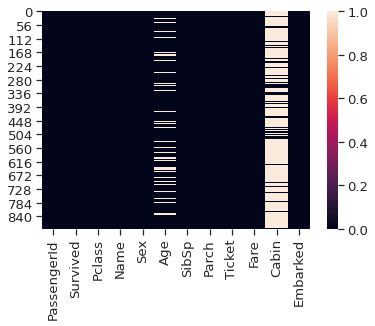

In [122]:
sn.heatmap(training_set.isnull())

Age and Cabin columns have the most missing data. Next, percentage of missing data for each of those columns.

In [123]:
def missing_data_percentage(column):
    percentage = (training_set[column].isna().sum()/len(training_set[column])) * 100
    print('{} column - missing data percentage: {:.2f} %' .format(column, percentage))

In [124]:
missing_data_percentage("Age")

Age column - missing data percentage: 19.87 %


In [125]:
missing_data_percentage("Cabin")

Cabin column - missing data percentage: 77.10 %


Most of the data (77.1 %) in the Cabin column is missing, so we will remove it from the datasets.

In [126]:
training_set.drop(columns=['Cabin'], axis=1, inplace=True)
test_set.drop(columns=['Cabin'], axis=1, inplace=True)

In [127]:
training_set['Age'].fillna(training_set['Age'].median(), inplace=True)
training_set['Embarked'].fillna(training_set['Embarked'].mode()[0], inplace=True)

# Detecting and removing outliers
****
Reducing the noise of the data

In [128]:
def box_plot(column):
    training_set.boxplot(by = "Survived",column = [column],grid = True)
    
# Small circles or unfilled dots are drawn on the chart to indicate where suspected outliers lie.
# Filled circles are used for known outliers.

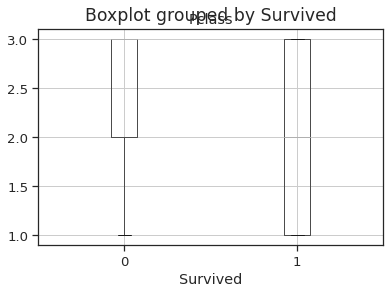

In [129]:
box_plot("Pclass")

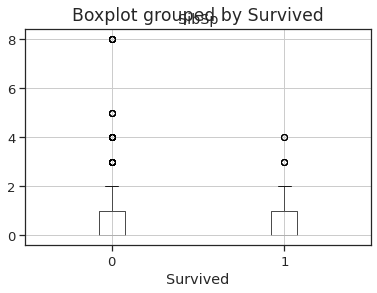

In [130]:
box_plot("SibSp")

In [131]:
training_set["SibSp"].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

SibSp feature has possible outliers, so we will remove all rows with values of feature SibSp == 8

In [132]:
indexes = training_set.index[training_set.SibSp == 8]
training_set.drop(indexes, inplace=True)

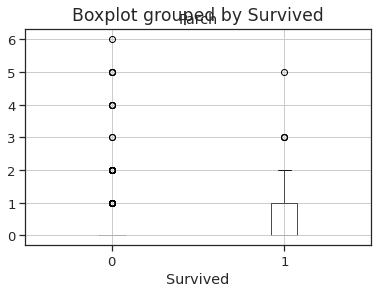

In [133]:
box_plot("Parch")

In [134]:
training_set["Parch"].value_counts()

0    678
1    118
2     73
3      5
5      5
4      4
6      1
Name: Parch, dtype: int64

Parch feature has possible outliers, so we will remove all rows with values of feature Parch == 6

In [135]:
indexes = training_set.index[training_set.Parch == 6]
training_set.loc[indexes]
training_set.drop(indexes, inplace=True)

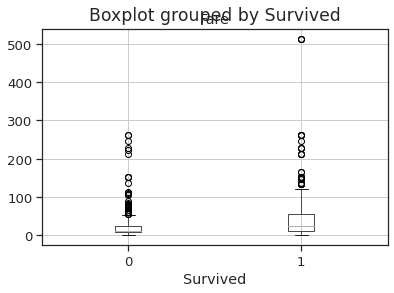

In [136]:
box_plot("Fare")

In [137]:
training_set["Fare"].value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
50.4958     1
13.8583     1
8.4583      1
7.7250      1
7.5208      1
Name: Fare, Length: 247, dtype: int64

Fare feature has possible outliers, so we will remove all rows with values of feature Fare higher than 100

In [138]:
indexes = training_set.index[training_set.Fare > 100]
training_set.loc[indexes]
indexes
training_set.drop(indexes, inplace=True)

# Correlation matrix
****
Used to detect correlation between features in order to reduce dimensionality if possible - showing lower triangle matrix below.

<AxesSubplot:>

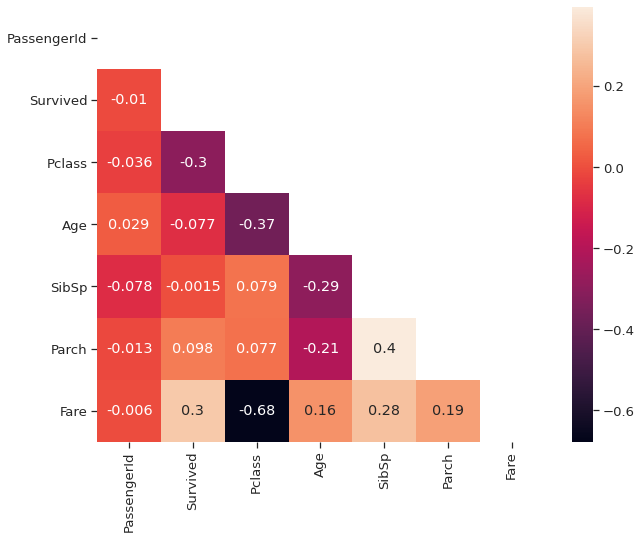

In [139]:
plt.figure(figsize=(10,8))
correlation_matrix = np.triu(training_set.corr())
sn.heatmap(training_set.corr(), annot = True, mask = correlation_matrix)

* PassengerId column correlation with other features shouldn't be taken into account  
* Survived column has **moderate** correlation to columns Fare and Pclass
* Pclass column has **moderate** correlation to Age and **high** correlation to Fare
* Age is **moderately** correlated to SibSp
* SibSp is **moderately** correlated to Parch

Features Name and Ticket will be removed because they have a lot of distinct values and aren't good predictors

In [140]:
training_set.drop(columns=['Name','Ticket'], axis=1, inplace=True)
test_set.drop(columns=['Name','Ticket'], axis=1, inplace=True)

# Survival rates
****

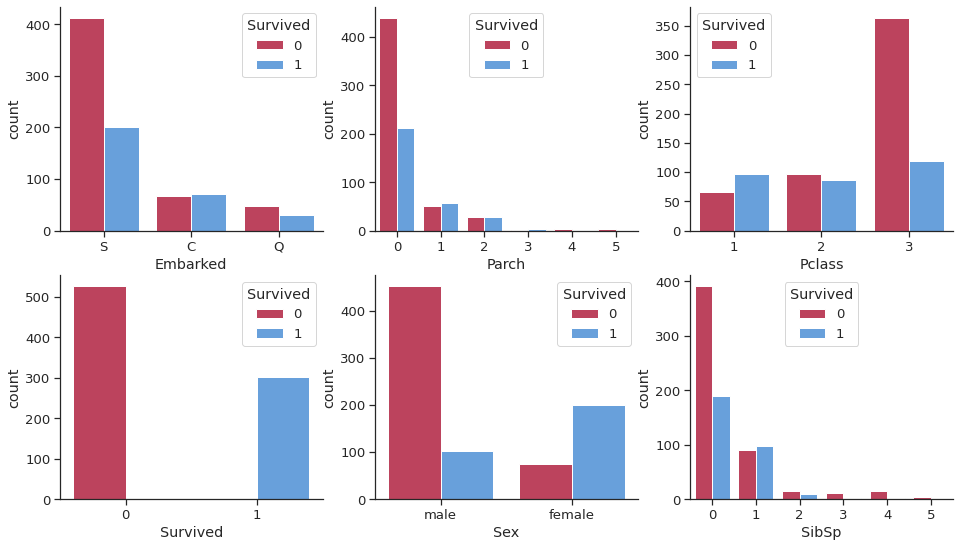

In [141]:
columns = ['Embarked', 'Parch', 'Pclass', 'Survived', 'Sex', 'SibSp']

plt.figure(figsize = (16, 14))
sn.set(font_scale = 1.2)
sn.set_style('ticks')

for i, column in enumerate(columns):
    plt.subplot(3, 3, i + 1)
    sn.countplot(data = training_set, x = column, hue = 'Survived', palette = ['#d02f52',"#55a0ee"])
    
sn.despine()

# Categorical data
****

In [142]:
training_set = pd.get_dummies(training_set, columns=['Pclass', 'Embarked' ], drop_first= True)
test_set = pd.get_dummies(test_set, columns=['Pclass', 'Embarked' ], drop_first= True)

training_set['Sex'].replace(['male','female'],[0,1],inplace=True)
test_set['Sex'].replace(['male','female'],[0,1],inplace=True)

Creating bins for Fare and Age features

In [143]:
from sklearn.preprocessing import LabelEncoder

training_set['FareBin'] = pd.qcut(training_set['Fare'], 5)
test_set['FareBin'] = pd.qcut(test_set['Fare'], 5)

label = LabelEncoder()
training_set['FareBin_Code'] = label.fit_transform(training_set['FareBin'])
test_set['FareBin_Code'] = label.fit_transform(test_set['FareBin'])

training_set.drop(['Fare'], 1, inplace=True)
test_set.drop(['Fare'], 1, inplace=True)

In [144]:
training_set['AgeBin'] = pd.qcut(training_set['Age'], 4)
test_set['AgeBin'] = pd.qcut(test_set['Age'], 4)

training_set['AgeBin_Code'] = label.fit_transform(training_set['AgeBin'])
test_set['AgeBin_Code'] = label.fit_transform(test_set['AgeBin'])

training_set.drop(['Age'], 1, inplace=True)
test_set.drop(['Age'], 1, inplace=True)

In [146]:
test_set.head()

,PassengerId,Sex,SibSp,Parch,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,FareBin,FareBin_Code,AgeBin,AgeBin_Code
0,892,0,0,0,0,1,1,0,"(7.796, 11.025]",1,"(27.0, 39.0]",2
1,893,1,1,0,0,1,0,1,"(-0.001, 7.796]",0,"(39.0, 76.0]",3
2,894,0,0,0,1,0,1,0,"(7.796, 11.025]",1,"(39.0, 76.0]",3
3,895,0,0,0,0,1,0,1,"(7.796, 11.025]",1,"(21.0, 27.0]",1
4,896,1,1,1,0,1,0,1,"(11.025, 21.438]",2,"(21.0, 27.0]",1


# Feature engineering
****

Creating Family size

In [108]:
training_set['Family_Size'] = training_set['Parch'] + training_set['SibSp']
test_set['Family_Size'] = test_set['Parch'] + test_set['SibSp']

In [109]:
training_set.drop(['PassengerId', 'SibSp', 'Parch'], axis = 1, inplace = True)
test_set.drop(['PassengerId', 'SibSp', 'Parch'], axis = 1, inplace = True)

# Creating the matrix of features and dependent variable vector
****

In [110]:
x_train = training_set.iloc[:,training_set.columns != 'Survived']
y_train = training_set.iloc[:,training_set.columns == 'Survived'].values.reshape(-1,1)

x_test = test_set

# Feature importance
****

In [111]:
#from sklearn.tree import DecisionTreeClassifier
#classifier_dt = DecisionTreeClassifier()
#classifier_dt.fit(x_train, y_train)
#y_pred = classifier_dt.predict(x_test)

#importances = pd.DataFrame(classifier_dt.feature_importances_, index = train_names)
#importances.sort_values(by = 0, inplace=True, ascending = False)
#importances = importances.iloc[0:6,:] 

#plt.figure(figsize=(8, 5)) 
#sns.barplot(x=0, y=importances.index, data=importances)
#sns.despine()

In [112]:
training_set.head()

,Survived,Sex,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,FareBin,FareBin_Code,AgeBin,AgeBin_Code,Family_Size
0,0,0,0,1,0,1,"(-0.001, 7.849]",0,"(0.419, 22.0]",0,1
1,1,1,0,0,0,0,"(30.539, 93.5]",4,"(35.0, 80.0]",3,1
2,1,1,0,1,0,1,"(7.849, 9.825]",1,"(22.0, 28.0]",1,0
3,1,1,0,0,0,1,"(30.539, 93.5]",4,"(28.0, 35.0]",2,1
4,0,0,0,1,0,1,"(7.849, 9.825]",1,"(28.0, 35.0]",2,0


In [113]:
test_set.head()

,Sex,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,FareBin,FareBin_Code,AgeBin,AgeBin_Code,Family_Size
0,0,0,1,1,0,"(7.796, 11.025]",1,"(27.0, 39.0]",2,0
1,1,0,1,0,1,"(-0.001, 7.796]",0,"(39.0, 76.0]",3,1
2,0,1,0,1,0,"(7.796, 11.025]",1,"(39.0, 76.0]",3,0
3,0,0,1,0,1,"(7.796, 11.025]",1,"(21.0, 27.0]",1,0
4,1,0,1,0,1,"(11.025, 21.438]",2,"(21.0, 27.0]",1,2


# Standard scaling
****

In [114]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

TypeError: float() argument must be a string or a number, not 'pandas._libs.interval.Interval'

In [ ]:
training_set.head()

In [ ]:
test_set.head()

****

# Fitting the model
****

**Support Vector Machine**

**Random Forest**

**Extreme Gradient Boosting**

In [ ]:
from sklearn.svm import SVC
classifier_svm = SVC(kernel = 'linear', random_state = 0)

print(x_train)
#classifier_svm.fit(x_train, y_train)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier(random_state = 0)
#classifier_rf.fit(x_train, y_train)

In [ ]:
from xgboost import XGBClassifier
classifier_xgb = XGBClassifier()
classifier_xgb.fit(x_train, y_train)

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier_lr = LogisticRegression()
#classifier_lr.fit(x_train, y_train)

# Predicting the test set results

In [ ]:
#y_pred_svm = classifier_svm.predict(x_test)
#y_pred_rf = classifier_rf.predict(x_test)
y_pred_xgb = classifier_xgb.predict(x_test)
#y_pred_lr = classifier_lr.predict(x_test)

# Confusion matrix and accuracy

In [ ]:
#from sklearn.metrics import confusion_matrix, accuracy_score
#cm = confusion_matrix(y_test, y_pred)
#print(cm)
#accuracy = accuracy_score(y_test, y_pred)
#print(accuracy)

# Output

In [ ]:
#output = pd.DataFrame({'PassengerId': test_set.PassengerId, 'Survived': y_pred_svm})

#output = pd.DataFrame({'PassengerId': test_set.PassengerId, 'Survived': y_pred_rf})

output = pd.DataFrame({'PassengerId': test_set.PassengerId, 'Survived': y_pred_xgb})

#output = pd.DataFrame({'PassengerId': test_set.PassengerId, 'Survived': y_pred_lr})
output.to_csv('my_submission_xgb.csv', index=False)
print("Your submission was successfully saved!")